# Informes y predicciones de COVID-19 en España 

Actualizado diariamente, este documento se [visualiza mejor aquí](https://nbviewer.jupyter.org/github/jaimevalero/COVID-19/blob/master/jupyter/Pain_Graphs.ipynb).

**Indice**

## [1. Datos de Madrid, hoy](#DatosMadrid)

## 2. Comparativas y predicciones

| Comparativas de dos dimensiones | Comparativas por comunidades  | Comparativas individuales | Predicciones |
| --- | --- | --- |  --- | 
| [Casos Vs fallecidos, historicos](#Comparativa_Casos_Fallecidos) | [Comparativa de fallecidos](#Comunidades_Fallecidos) | [Fallecidos hoy, en España](#Pico_España) | [Predicción de fallecidos, en España](#Prediccion_Fallecidos_España)|
| [Casos Vs fallecidos, hoy](#Comparativa_Casos_Fallecidos_Hoy) |   [Comparativa de fallecidos, hoy](#Comunidades_Fallecidos_Hoy) | [Fallecidos hoy, en Madrid](#Reporte_Fallecidos_hoy_absoluto_Madrid)|  [Predicción de fallecidos, en Madrid](#Prediccion_Fallecidos_hoy_absoluto_Madrid)
| [Casos Vs fallecidos, variación diaria](#Comparativa_Casos_Fallecidos_Variacion_Diaria) |[Comparativa de mortalidad](#Comunidades_Mortalidad)| [Fallecidos hoy, en Cataluña](#Reporte_Fallecidos_hoy_absoluto_Cataluña)|  [Predicción de fallecidos, en Cataluña](#Prediccion_Fallecidos_hoy_absoluto_Cataluña)
|  |  [Comparativa de curados](#Curados)| [Fallecidos hoy, en Castilla y León](#Reporte_Fallecidos_hoy_absoluto_CyL)|[Predicción de fallecidos, en Castilla y León](#Prediccion_Fallecidos_hoy_absoluto_CyL)
|  | | [Fallecidos hoy, en Castilla La Mancha](#Reporte_Fallecidos_hoy_absoluto_CM) |[Predicción de fallecidos, en Castilla La Mancha](#Prediccion_Fallecidos_hoy_absoluto_CM)
|  |  | | |
  



## [3. ¿ Son reales estos datos ?](#Reales)




In [1]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML

def Insertar_Enlace(cell_name):
    display(HTML('<a id="'+ cell_name +'"></a>'))

Insertar_Enlace('DatosMadrid')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
comunidad.head(10)




,Lugar,Casos,Casos hoy absoluto,Casos hoy variacion respecto ayer,Casos hoy porcentaje,Fallecidos,Fallecidos hoy absoluto,Fallecidos hoy variacion respecto ayer,Fallecidos hoy porcentaje,Tasa Mortalidad,Curados,Curados hoy absoluto,Casos excluidos curados,Proporcion Curados hoy absoluto / Casos hoy absoluto,UCI,Hospitalizados
Fecha,,,,,,,,,,,,,,,,
2020-05-06,Madrid,63416,427,-167,0.006733,8466,46,2,0.005433,0.133499,38331,329.0,25085,0.770492,3465,41031
2020-05-05,Madrid,62989,594,404,0.009430,8420,44,0,0.005226,0.133674,38002,194.0,24987,0.326599,3442,40851
2020-05-04,Madrid,62395,190,58,0.003045,8376,44,4,0.005253,0.134242,37808,104.0,24587,0.547368,3431,40741
2020-05-03,Madrid,62205,132,-112,0.002122,8332,40,-30,0.004801,0.133944,37704,174.0,24501,1.318182,3421,40597
2020-05-02,Madrid,62073,244,-414,0.003931,8292,70,24,0.008442,0.133585,37530,376.0,24543,1.540984,3404,40457
2020-05-01,Madrid,61829,658,252,0.010642,8222,46,-25,0.005595,0.132980,37154,447.0,24675,0.679331,3392,40293
2020-04-30,Madrid,61171,406,-575,0.006637,8176,71,14,0.008684,0.133658,36707,393.0,24464,0.967980,3377,40076
2020-04-29,Madrid,60765,981,618,0.016144,8105,57,-5,0.007033,0.133383,36314,473.0,24451,0.482161,3355,39850
2020-04-28,Madrid,59784,363,68,0.006072,8048,62,-2,0.007704,0.134618,35841,276.0,23943,0.760331,3338,39634


In [2]:
import pandas as pd


def Get_Dimensions_All_CCAA(Atributos,media_movil ):
    array = []
    dias_a_considerar = 4 if media_movil else 1
    for ca in COMUNIDADES: 
        
        comunidad = Loading_data.Get_Comunidad(ca).head(dias_a_considerar)
        comunidad = comunidad.reset_index() # Resets the index, makes factor a column
        if media_movil : comunidad = pd.DataFrame(comunidad.mean(axis=0)).T 
        temp_dict = {}
        temp_dict['Lugar'] = ca
        for attr in Atributos:
            temp_dict[attr] = comunidad[attr].iloc[0]
        array.append(temp_dict)

    return pd.DataFrame.from_records(array)



In [3]:
import scipy.stats as spstats
from matplotlib import pyplot as plt    


def Print_Two_Cordinates_CCAA(df, add_LR=False):
    fig,ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.axhline(y=0, color='blue')
    ax.axvline(x=0, color='blue')

    for k,d in df.groupby('Lugar'):
        ax.scatter(d[df.columns[1]], d[df.columns[2]], label=k)

    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    
    if add_LR:
        slope, intercept, r_value, p_value, std_err = spstats.linregress(df[df.columns[1]], df[df.columns[2]])
        plt.plot(df[df.columns[1]], intercept + slope*df[df.columns[1]], 'r', label='fitted line')
        #.format(round(slope, 2),round(intercept, 2),round(r_value, 2))
        note2add = f"""slope: {slope:12.4f}\nintercept: {intercept:8.2f}\nr2: {r_value**2:15.4f}"""
        plt.annotate(note2add,xy=(0.7,0.3), xycoords='figure fraction')
        
    ax.set_xlabel(df.columns[1])
    ax.set_ylabel(df.columns[2])
    ax.set_title(df.columns[1]+ ' VS. ' + df.columns[2])
    
    return plt


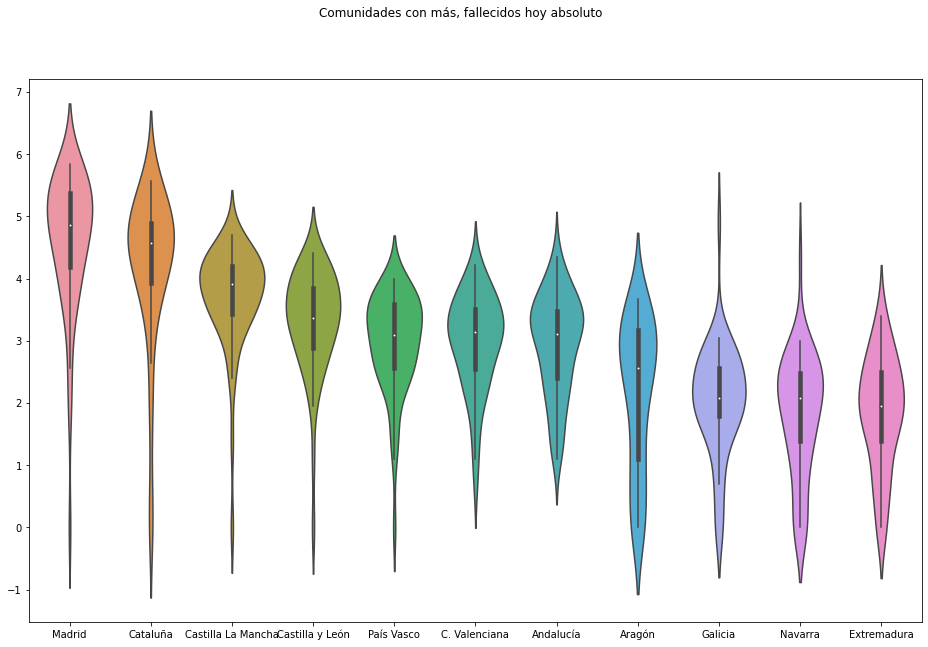

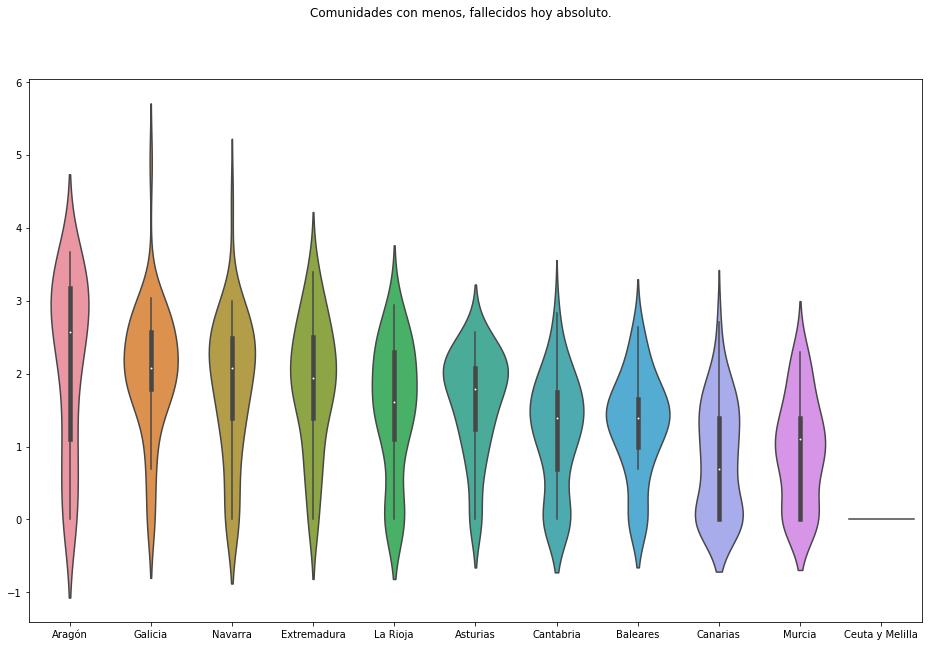

In [4]:
import numpy as np 
import seaborn as sns

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Single_Dimension(dimension ):
    df = pd.DataFrame()
    df_tmp = pd.DataFrame()
    array = []
    #
    for ca in COMUNIDADES:
        df_tmp = Loading_data.Get_Comunidad(ca)
        new = df_tmp[[dimension]].copy()
        new.rename(columns={dimension: ca}, inplace=True)
        array.append(new)
    #
    df =  pd.concat(array, axis=1)
    return df

def plot_violin(dimension):
    """ Muestra la distribucion logaritmica por comunidades, de una dimension"""
    df = Get_Single_Dimension(dimension) 
    # Ordenamos comunidades 
    s = df.sum()
    df = df[s.sort_values(ascending=False).index[:]]

    # Pasamos a logaritmo
    df2 = np.log(df)
    df2.replace(-np.inf,  np.nan, inplace=True)
    display(HTML("<h2>Comparativa de distribucion de '" +dimension+ "', en cada CC.AA </h2>"))
    display(HTML("Distribuciones convertidas a logaritmos neperianos, para facilitar la comparación."))

    # primer grafico
    f, ax = plt.subplots()
    f.set_size_inches( 16, 10)
    f.suptitle("Comunidades con más, " + dimension.lower())
    sns.violinplot(data=df2.iloc[:,:-7])

    #segundo grafico
    f, ax = plt.subplots()
    f.set_size_inches( 16, 10)
    f.suptitle("Comunidades con menos, " + dimension.lower()+".")
    sns.violinplot(data=df2.iloc[:,7:])
    return df

dimension = 'Fallecidos hoy absoluto'
df = plot_violin(dimension)


In [5]:
df

,Madrid,Cataluña,Castilla La Mancha,Castilla y León,País Vasco,C. Valenciana,Andalucía,Aragón,Galicia,Navarra,Extremadura,La Rioja,Asturias,Cantabria,Baleares,Canarias,Murcia,Ceuta y Melilla
Fecha,,,,,,,,,,,,,,,,,,
2020-05-06,46,75,31,15,11,12,14,18,9,5,1,1,3,1,1,1,0,0
2020-05-05,44,50,26,14,12,10,4,8,4,5,2,1,0,1,1,1,2,0
2020-05-04,44,35,25,18,12,5,7,1,6,4,0,0,4,2,0,1,0,0
2020-05-03,40,48,31,12,8,6,3,0,6,2,2,1,1,2,0,0,2,0
2020-05-02,70,76,36,18,9,13,15,12,2,2,7,1,6,1,4,4,0,0
2020-05-01,46,86,35,18,16,9,31,10,8,7,5,1,0,1,5,1,2,0
2020-04-30,71,70,27,16,22,18,19,3,0,3,6,2,7,0,3,1,0,0
2020-04-29,57,97,40,26,19,18,20,1,135,16,7,4,5,3,4,1,0,0
2020-04-28,62,109,31,20,14,11,11,9,7,0,5,6,8,2,2,2,2,0


In [6]:


import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Comparar_Dos_Dimensiones(Atributos, media_movil=False, add_LR=False ):
    """ Compara dos dimensiones de atributos, Ma indica si hacerlo con la media movil"""
    
    df = Get_Dimensions_All_CCAA(Atributos,media_movil )
    df = df.sort_values(by=[df.columns[1],df.columns[2]])
    plt = Print_Two_Cordinates_CCAA(df, add_LR)
    plt.show()
    print(  'Total: '  + df.columns[1], df[df.columns[1]].sum() )
    print(  'Total: '  + df.columns[2], df[df.columns[2]].sum() )
    display(HTML(df.set_index('Lugar').to_html(index=True)))
    return 

  

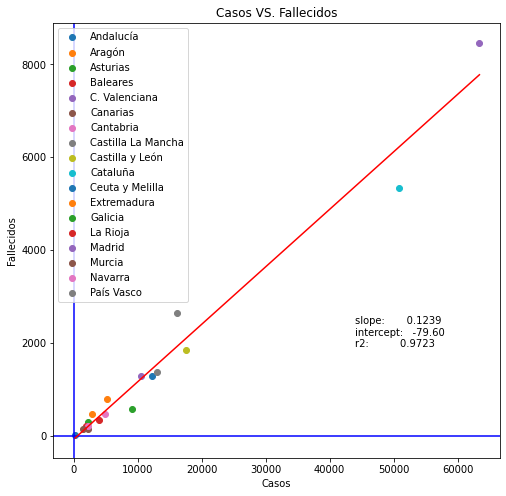

Total: Casos 220325
Total: Fallecidos 25857


,Casos,Fallecidos
Lugar,,
Ceuta y Melilla,228,6
Murcia,1498,136
Baleares,1921,199
Cantabria,2213,199
Canarias,2231,143
Asturias,2310,287
Extremadura,2865,463
La Rioja,3980,337
Navarra,4966,476


In [7]:
Insertar_Enlace("Comparativa_Casos_Fallecidos")
Comparar_Dos_Dimensiones(['Casos', 'Fallecidos'],add_LR=True )  


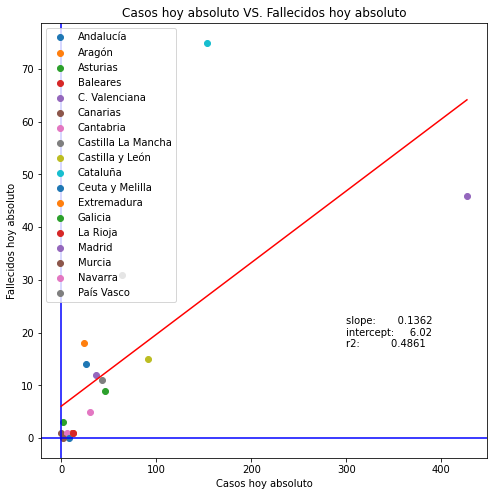

Total: Casos hoy absoluto 996
Total: Fallecidos hoy absoluto 244


,Casos hoy absoluto,Fallecidos hoy absoluto
Lugar,,
Canarias,0,1
Murcia,2,0
Asturias,2,3
Cantabria,6,1
Ceuta y Melilla,8,0
Baleares,11,1
Extremadura,13,1
La Rioja,13,1
Aragón,24,18


In [8]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Hoy")

Comparar_Dos_Dimensiones(['Casos hoy absoluto', 'Fallecidos hoy absoluto'],add_LR=True )   

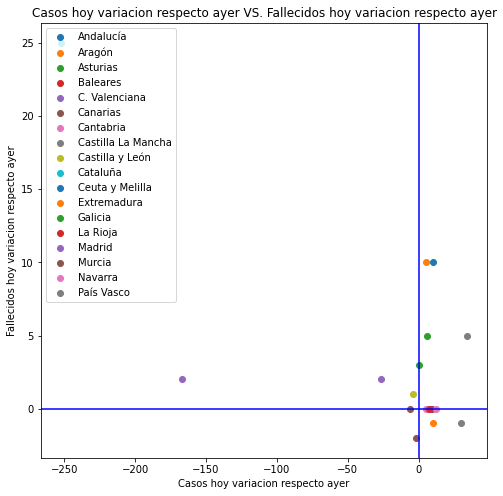

Total: Casos hoy variacion respecto ayer -322
Total: Fallecidos hoy variacion respecto ayer 59


,Casos hoy variacion respecto ayer,Fallecidos hoy variacion respecto ayer
Lugar,,
Cataluña,-252,25
Madrid,-167,2
C. Valenciana,-27,2
Canarias,-6,0
Castilla y León,-4,1
Murcia,-2,-2
Asturias,0,3
Cantabria,5,0
Aragón,5,10


In [9]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Variacion_Diaria")

Comparar_Dos_Dimensiones(['Casos hoy variacion respecto ayer', 'Fallecidos hoy variacion respecto ayer'])

In [10]:
# Cargamos datos
import pandas as pd
import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Dimension_CCAA(Dimension,include_nation=False):
    def Do_Stuff_to_DF(df):
        df = df.sort_values(by='Fecha')
        # df = df.reset_index() # Resets the index, makes factor a column    
        df = df[df["Casos"] >= 100]
        return df
        
    dimension_df = pd.DataFrame()
    for ca in COMUNIDADES: 
        df = Loading_data.Get_Comunidad(ca)
        df = Do_Stuff_to_DF(df)
        dimension_df[ca] = df[Dimension]
    if include_nation:
        df = Loading_data.Get_Nacion()
        df = Do_Stuff_to_DF(df)
        dimension_df['TOTAL'] = df[Dimension]
        
    return dimension_df 


In [11]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, HTML
import pandas as pd

import numpy as np


def compare_charts_median(Dimension,df): 
    short_df = df.tail(1)
    short_df = short_df.T
    short_df = short_df.sort_values(by=(short_df.columns[0]))
    short_df.columns = [Dimension]

    #mean_y = short_df.median(axis=1)[0]
    #mean_y= df.tail(1).T.median().values[0]
    median_y= df.tail(1).T.drop(axis=0,labels=(['TOTAL'] if 'TOTAL' in short_df.index else [])).median().values[0]
    x = short_df.index
    y = short_df[Dimension]

    plt.figure(figsize = (10, 5))
    plt.scatter(x, y, c= "red", alpha = 0.5)
    plt.title(Dimension + " by region")
    color = 'blue'
    plt.xticks(rotation=90)
    plt.axhline(median_y, c = color, alpha = 0.5, lw = 1)
    plt.annotate('Median ' + Dimension+  ' is {}'.format(round(median_y, 2)),
            xy=(8.5, median_y),
            xycoords='data',
            xytext=(-50, 50), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color = "k", alpha = 0.5),
            color = color)
    return

def compare_charts_time(Dimension,df):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    for ca in df.columns:
        plt.plot(df[ca])
    plt.legend(df.columns)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

    fig.suptitle('Comparativa de: '+Dimension, fontsize=20)
    plt.show()
    return 

def Report_Location(Dimension,include_nation=False):
    # Ger Data
    df = Get_Dimension_CCAA(Dimension,include_nation)
    # Compare chart
    compare_charts_time(Dimension,df)
    # Compare median chart
    compare_charts_median(Dimension,df)
    
    with pd.option_context("display.max_rows", 1000):
        display(HTML(df.to_html()))
    return 

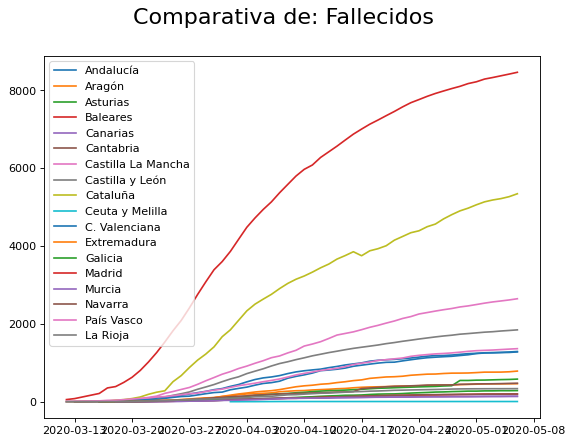

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,4,NaN,NaN,NaN,NaN,56,NaN,NaN,11,2
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,5,1.0,4,NaN,NaN,NaN,NaN,81,NaN,0.0,14,2
2020-03-16,7,11.0,1.0,NaN,1.0,NaN,17,9.0,12,NaN,5.0,2.0,2.0,213,NaN,1.0,23,4
2020-03-17,11,12.0,1.0,NaN,2.0,NaN,17,12.0,18,NaN,13.0,3.0,3.0,355,NaN,2.0,36,5
2020-03-18,19,13.0,1.0,1.0,3.0,NaN,28,22.0,41,NaN,22.0,6.0,3.0,390,0.0,3.0,40,5
2020-03-19,23,15.0,1.0,2.0,3.0,NaN,42,29.0,55,NaN,24.0,8.0,4.0,498,0.0,4.0,53,5
2020-03-20,30,17.0,2.0,2.0,4.0,1.0,62,43.0,82,NaN,33.0,10.0,5.0,628,0.0,5.0,71,7
2020-03-21,40,22.0,5.0,4.0,7.0,2.0,84,55.0,122,NaN,50.0,12.0,9.0,804,1.0,9.0,85,15
2020-03-22,47,24.0,8.0,4.0,9.0,5.0,112,74.0,191,NaN,69.0,14.0,12.0,1021,1.0,14.0,97,18


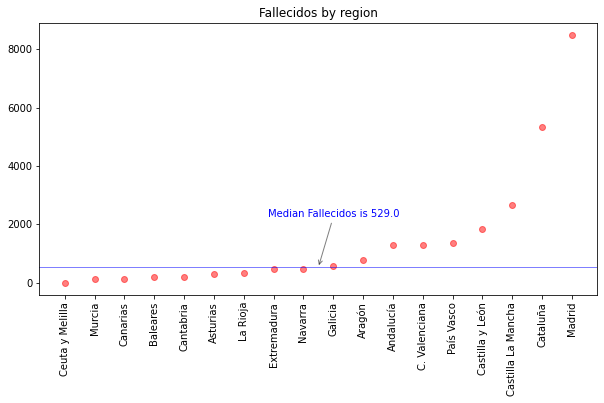

In [12]:
Insertar_Enlace("Comunidades_Fallecidos")
Report_Location("Fallecidos")

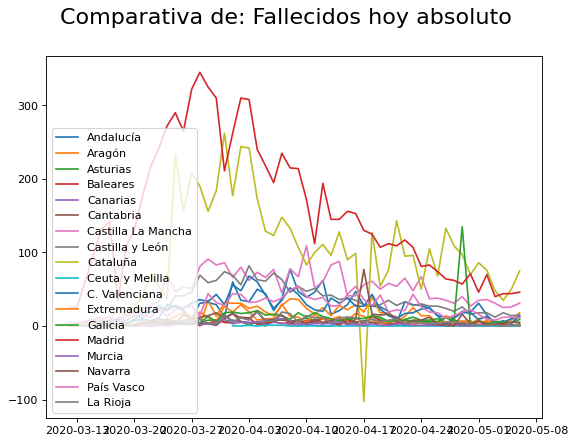

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,25,NaN,NaN,5,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,4,1.0,0,NaN,NaN,NaN,NaN,25,NaN,0.0,3,0
2020-03-16,7,4.0,0.0,NaN,1.0,NaN,12,8.0,8,NaN,4.0,1.0,2.0,132,NaN,1.0,9,2
2020-03-17,4,1.0,0.0,NaN,1.0,NaN,0,3.0,6,NaN,8.0,1.0,1.0,142,NaN,1.0,13,1
2020-03-18,8,1.0,0.0,0.0,1.0,NaN,11,10.0,23,NaN,9.0,3.0,0.0,35,0.0,1.0,4,0
2020-03-19,4,2.0,0.0,1.0,0.0,NaN,14,7.0,14,NaN,2.0,2.0,1.0,108,0.0,1.0,13,0
2020-03-20,7,2.0,1.0,0.0,1.0,0.0,20,14.0,27,NaN,9.0,2.0,1.0,130,0.0,1.0,18,2
2020-03-21,10,5.0,3.0,2.0,3.0,1.0,22,12.0,40,NaN,17.0,2.0,4.0,176,1.0,4.0,14,8
2020-03-22,7,2.0,3.0,0.0,2.0,3.0,28,19.0,69,NaN,19.0,2.0,3.0,217,0.0,5.0,12,3


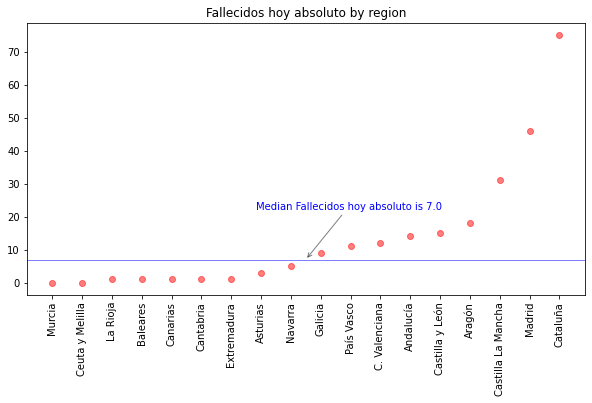

In [13]:
Insertar_Enlace("Comunidades_Fallecidos_Hoy")

Report_Location("Fallecidos hoy absoluto") 

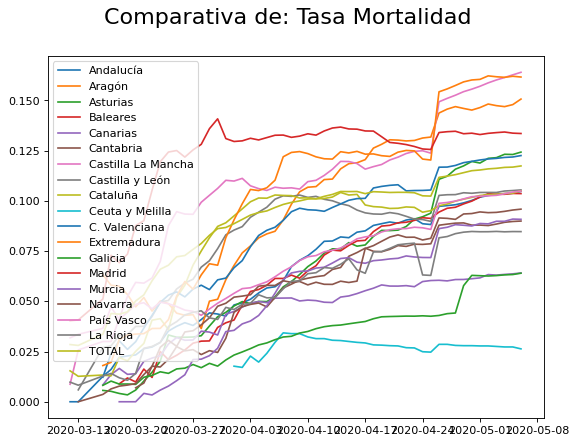

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja,TOTAL
Fecha,,,,,,,,,,,,,,,,,,,
2020-03-12,0.000000,NaN,NaN,NaN,NaN,NaN,0.008696,NaN,0.015385,NaN,NaN,NaN,NaN,0.040346,NaN,NaN,0.031792,0.009756,0.028475
2020-03-13,0.000000,NaN,NaN,NaN,NaN,NaN,0.025773,0.005917,0.012658,NaN,NaN,NaN,NaN,0.040704,NaN,0.000000,0.033573,0.008230,0.028035
2020-03-16,0.012635,0.063218,0.005650,NaN,0.008403,NaN,0.029982,0.026946,0.013289,NaN,0.012225,0.018018,0.008163,0.051140,NaN,0.003650,0.036508,0.012821,0.033620
2020-03-17,0.016105,0.057971,0.005181,NaN,0.013514,NaN,0.029982,0.027842,0.012912,NaN,0.024030,0.019608,0.010274,0.072880,NaN,0.006390,0.047059,0.014085,0.043926
2020-03-18,0.022119,0.057522,0.004132,0.008929,0.016575,NaN,0.041481,0.032934,0.021972,NaN,0.030303,0.030928,0.008798,0.069186,0.000000,0.007772,0.041110,0.011933,0.043599
2020-03-19,0.022817,0.053381,0.003425,0.011834,0.013636,NaN,0.052434,0.033410,0.020355,NaN,0.026059,0.033195,0.008830,0.073484,0.000000,0.008299,0.044538,0.010684,0.044731
2020-03-20,0.023310,0.047222,0.005814,0.009852,0.013937,0.006944,0.059387,0.037489,0.025076,NaN,0.029864,0.033670,0.008651,0.087648,0.000000,0.009025,0.048464,0.014085,0.050150
2020-03-21,0.026403,0.051887,0.010288,0.016260,0.020115,0.009302,0.059030,0.037517,0.029027,NaN,0.036684,0.033898,0.012179,0.090124,0.004167,0.013554,0.049275,0.026596,0.053197
2020-03-22,0.027246,0.045113,0.014679,0.012085,0.021739,0.017730,0.061572,0.042431,0.040604,NaN,0.043017,0.036458,0.013115,0.105236,0.003378,0.017632,0.046257,0.027523,0.060199


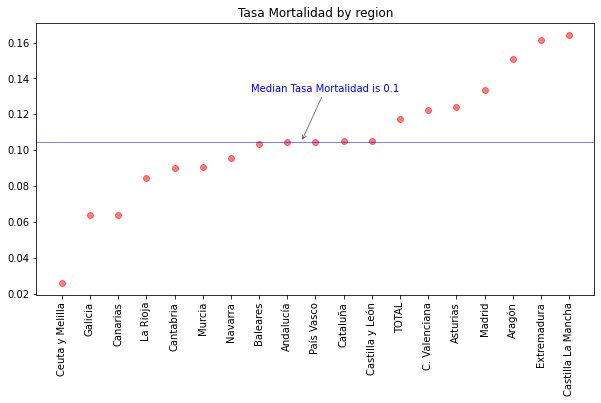

In [14]:
Insertar_Enlace("Comunidades_Mortalidad")

Report_Location("Tasa Mortalidad",True)

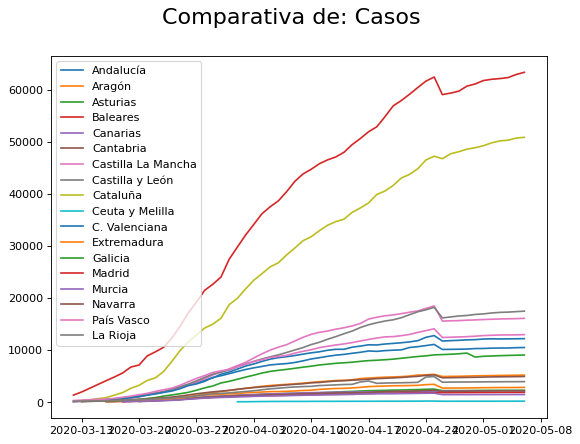

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,115,NaN,NaN,NaN,NaN,NaN,115,NaN,260,NaN,NaN,NaN,NaN,1388,NaN,NaN,346,205
2020-03-13,219,NaN,NaN,NaN,NaN,NaN,194,169.0,316,NaN,NaN,NaN,NaN,1990,NaN,130.0,417,243
2020-03-16,554,174.0,177.0,NaN,119.0,NaN,567,334.0,903,NaN,409.0,111.0,245.0,4165,NaN,274.0,630,312
2020-03-17,683,207.0,193.0,NaN,148.0,NaN,567,431.0,1394,NaN,541.0,153.0,292.0,4871,NaN,313.0,765,355
2020-03-18,859,226.0,242.0,112.0,181.0,NaN,675,668.0,1866,NaN,726.0,194.0,341.0,5637,122.0,386.0,973,419
2020-03-19,1008,281.0,292.0,169.0,220.0,NaN,801,868.0,2702,NaN,921.0,241.0,453.0,6777,167.0,482.0,1190,468
2020-03-20,1287,360.0,344.0,203.0,287.0,144.0,1044,1147.0,3270,NaN,1105.0,297.0,578.0,7165,204.0,554.0,1465,497
2020-03-21,1515,424.0,486.0,246.0,348.0,215.0,1423,1466.0,4203,NaN,1363.0,354.0,739.0,8921,240.0,664.0,1725,564
2020-03-22,1725,532.0,545.0,331.0,414.0,282.0,1819,1744.0,4704,NaN,1604.0,384.0,915.0,9702,296.0,794.0,2097,654


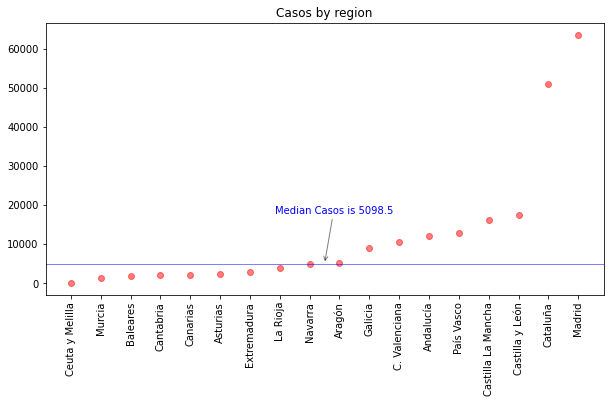

In [15]:
Insertar_Enlace("Comunidades_Casos")

Report_Location("Casos") 

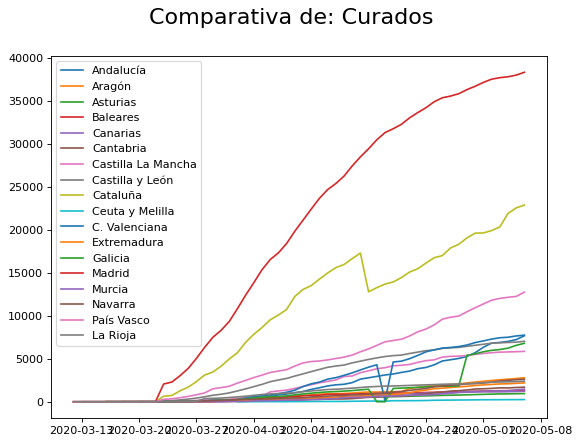

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,0.0,0,0
2020-03-16,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-17,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-18,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-19,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-20,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-21,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-22,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0


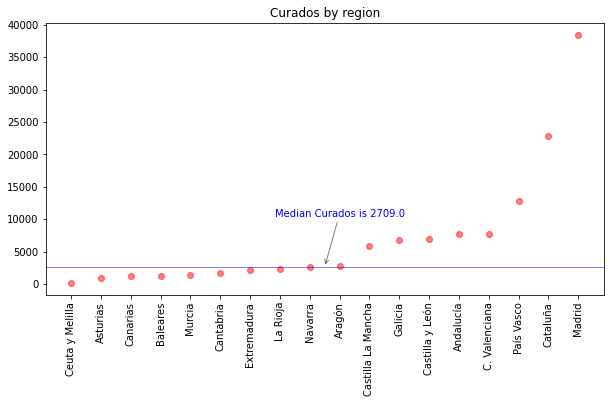

In [16]:
Insertar_Enlace("Curados")

Report_Location("Curados")

## ¿Hemos alcanzado el pico de la curva?


### Casos totales españa, evolucion


,Total Fallecidos,Total Fallecidos hoy absoluto,MA Total Fallecidos hoy absoluto,Variacion MA Total Fallecidos hoy absoluto
Fecha,,,,
2020-03-12,74,NaN,NaN,NaN
2020-03-13,107,33.0,NaN,NaN
2020-03-16,308,201.0,NaN,NaN
2020-03-17,490,182.0,NaN,NaN
2020-03-18,597,107.0,130.75,NaN
2020-03-19,766,169.0,164.75,34.00
2020-03-20,1002,236.0,173.50,8.75
2020-03-21,1326,324.0,209.00,35.50
2020-03-22,1720,394.0,280.75,71.75


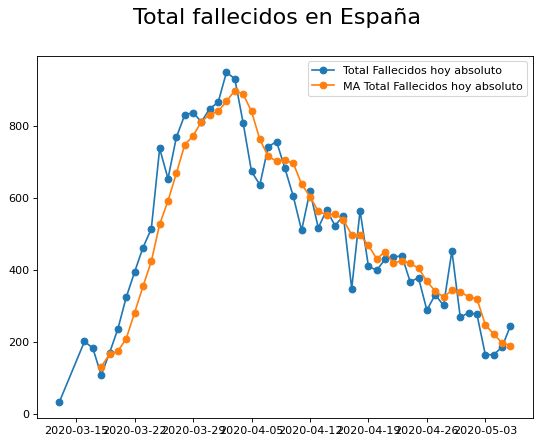

In [17]:
# Casos totales españa, evolucion
import Loading_data 

MOVING_AVERAGE_WINDOW=4

def get_fallecidos_nacion(window_size=MOVING_AVERAGE_WINDOW):
    Dimension = 'Fallecidos'
    
    Insertar_Enlace("Pico_España")

    df = Get_Dimension_CCAA(Dimension)

    df['Total Fallecidos'] = df.sum(axis=1)
    df['Total Fallecidos']

    CONVERT_INT_COLUMNS = ['Total Fallecidos']
    for column in CONVERT_INT_COLUMNS :
        df[column] = df[column].fillna(0)
        df[column] = df[column].astype(np.int64)

    df['Total Fallecidos hoy absoluto'] = df['Total Fallecidos'] - df['Total Fallecidos'].shift(1)
    df['MA Total Fallecidos hoy absoluto'] = df['Total Fallecidos hoy absoluto'].rolling(window=window_size).mean()

    df['Variacion MA Total Fallecidos hoy absoluto'] = df['MA Total Fallecidos hoy absoluto'] - df['MA Total Fallecidos hoy absoluto'].shift(1)
    return df

df = get_fallecidos_nacion()
df_plt = df[['Total Fallecidos hoy absoluto','MA Total Fallecidos hoy absoluto']]
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(df_plt, marker='o') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.legend(df_plt.columns)
fig.suptitle( "Total fallecidos en España", fontsize=20)

df[['Total Fallecidos',
    'Total Fallecidos hoy absoluto',
    'MA Total Fallecidos hoy absoluto',
    'Variacion MA Total Fallecidos hoy absoluto']]



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-16,128.090925,11.327376,183.411922,128.090925,128.090925,-31.455681,-31.455681,-31.455681,-31.455681,-31.455681,-31.455681,0.0,0.0,0.0,96.635244
2,2020-03-17,179.548356,98.116480,266.290251,179.548356,179.548356,-0.037856,-0.037856,-0.037856,-0.037856,-0.037856,-0.037856,0.0,0.0,0.0,179.510501
3,2020-03-18,231.005788,191.246234,363.758358,231.005788,231.005788,45.093170,45.093170,45.093170,45.093170,45.093170,45.093170,0.0,0.0,0.0,276.098958
4,2020-03-19,282.463219,216.221493,386.403540,282.463219,282.463219,15.270292,15.270292,15.270292,15.270292,15.270292,15.270292,0.0,0.0,0.0,297.733510
5,2020-03-20,333.920650,249.910635,417.328859,333.920650,333.920650,-2.550985,-2.550985,-2.550985,-2.550985,-2.550985,-2.550985,0.0,0.0,0.0,331.369665
6,2020-03-21,385.378081,310.851596,475.140220,385.378081,385.378081,9.385135,9.385135,9.385135,9.385135,9.385135,9.385135,0.0,0.0,0.0,394.763216
7,2020-03-22,436.835512,314.406013,489.188874,436.835512,436.835512,-35.704075,-35.704075,-35.704075,-35.704075,-35.704075,-35.704075,0.0,0.0,0.0,401.131437
8,2020-03-23,488.292943,369.409150,534.458818,488.292943,488.292943,-31.455681,-31.455681,-31.455681,-31.455681,-31.455681,-31.455681,0.0,0.0,0.0,456.837262
9,2020-03-24,539.750374,458.868522,625.407019,539.750374,539.750374,-0.037856,-0.037856,-0.037856,-0.037856,-0.037856,-0.037856,0.0,0.0,0.0,539.712518
10,2020-03-25,591.207805,546.541243,723.676273,591.207805,591.207805,45.093170,45.093170,45.093170,45.093170,45.093170,45.093170,0.0,0.0,0.0,636.300975


Prediccion total para Total Fallecidos hoy absoluto : 26437.73596908292


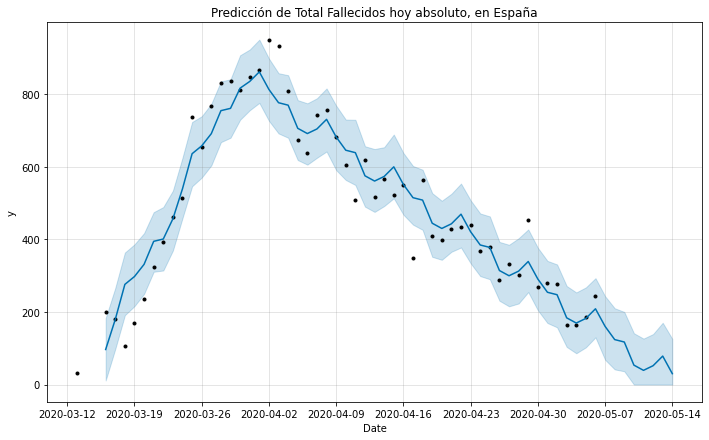

In [18]:
import fbprophet
def Get_Prediction_Nacion(df,dimension,location='España' , link=None) :
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df = df.dropna()
    df = df.reset_index()
    df.columns = ['ds','y']


    df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
    df_prophet.fit(df)

    # Make a future dataframe for 2 years
    df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
    # Make predictions
    df_forecast = df_prophet.predict(df_forecast)
    df_forecast

    df_forecast = df_forecast[df_forecast["yhat"] >= 0]
    df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0
    
    if link is not None:
        Insertar_Enlace(link)

    df_prophet.plot(df_forecast, xlabel = 'Date' )
    plt.title('Predicción de ' + dimension + ", en " + location )

    suma = df_forecast.trend.sum()
    display(HTML(pd.DataFrame(df_forecast).to_html()))

    print ("Prediccion total para " + dimension + " : " + str(suma) )
    return df_forecast
    
    
Insertar_Enlace("Prediccion_Fallecidos_España")
    
prediccion = Get_Prediction_Nacion( df = get_fallecidos_nacion(), 
                                   dimension = 'Total Fallecidos hoy absoluto')

In [19]:
def Get_Predictions_Compare(df,dimension,location='España' , link=None) :
    if link is not None:
        Insertar_Enlace(link)


    display(HTML("<h2>Comparativa de predicciones, hoy contra días pasados, " +dimension+ " en " +  location+ "</h2>"))

        
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df = df.dropna()
    df = df.reset_index()

    df.columns = ['ds','y']
    
    df_original = df.copy()

    
    results = pd.DataFrame()
    array_results_temp = []
    for i in range(4):
        
        if i >= 1 : df = df.iloc[1:]
    
        fecha=max(df.ds)
        fecha_short = str(fecha)[:10]
        

        df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
        df_prophet.fit(df)

        # Make a future dataframe 
        df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
        # Make predictions
        df_forecast = df_prophet.predict(df_forecast)
        suma = df_forecast.yhat.sum()
            
        df_forecast[fecha_short] = df_forecast.yhat
        
        array_results_temp.append(pd.DataFrame(df_forecast[['ds',fecha_short]]))


    df_1 = pd.merge(array_results_temp[0], array_results_temp[1], how ='outer', on ='ds') 
    df_2 = pd.merge(df_1                 , array_results_temp[2], how ='outer', on ='ds') 
    df_3 = pd.merge(df_2                 , array_results_temp[3], how ='outer', on ='ds') 
    df_4 = pd.merge(df_3                 , df_original          , how ='outer', on ='ds') 
    df_4['datos reales'] = df_4['y']
    del df_4['y']

        
    df_chart = df_4
    df_chart = df_chart.set_index('ds')
    df_chart = df_chart.head(70).tail(40)

    for c in df_chart.columns: 
        df_chart.loc[df_chart[c] < 0, c] = 0

    df_chart.drop(df_chart.loc[df_chart.sum(axis=1)==0].index, inplace=True)
    df_chart.drop(columns=df_chart.columns[df_chart.sum()==0], inplace=True)


    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df_chart) 
    plt.title("Gráfico de comparativa de predicciones " + dimension +", en " + location )
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=90)
    plt.legend(df_chart.columns)



    #print(df_chart)

    print("Las predicciones del total de "+ dimension+  " en " +  location+  ", cambian dia a dia")
    print(df_chart.sum(axis=0) )

    return df_chart



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en España, cambian dia a dia
2020-05-06      9178.513523
2020-05-05      9061.159580
2020-05-04      8976.277795
2020-05-03      9049.991445
datos reales    8368.000000
dtype: float64


,2020-05-06,2020-05-05,2020-05-04,2020-05-03,datos reales
ds,,,,,
2020-04-14,573.650758,574.428077,577.377080,576.775429,567.0
2020-04-15,600.087524,594.977941,591.671820,594.790462,523.0
2020-04-16,551.589627,551.297861,548.453367,550.951058,551.0
2020-04-17,515.093332,515.040383,511.753760,515.026577,348.0
2020-04-18,508.387463,507.677989,508.953044,507.000689,565.0
2020-04-19,444.668193,443.728116,448.682399,442.894885,410.0
2020-04-20,430.286527,433.500999,435.968181,435.406085,399.0
2020-04-21,443.078938,442.087655,442.432832,444.015282,430.0
2020-04-22,469.584549,462.658408,457.716821,462.059356,435.0


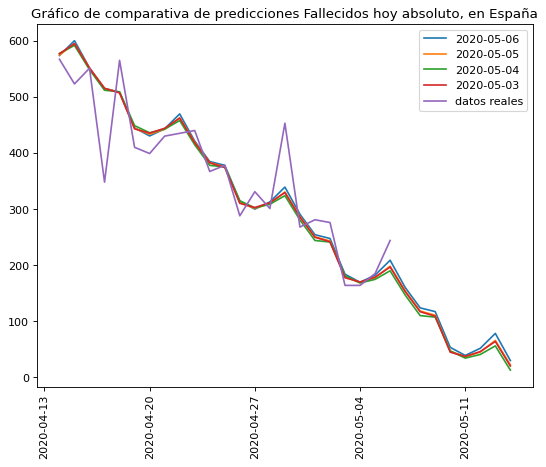

In [20]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'España'

link="Prediccion_Fallecidos_hoy_absoluto_España"


df = get_fallecidos_nacion()[['Total Fallecidos hoy absoluto']] 
df.columns = [ 'Fallecidos hoy absoluto' ]
df.sort_index(inplace=True,ascending=False)

prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

In [21]:
MOVING_AVERAGE_WINDOW = 4
def report_single_location_single_dimension(location,dimension,window_size=MOVING_AVERAGE_WINDOW):
    
    Dimension = 'Fallecidos'
    labelMa = f'Moving Average ({window_size}) {dimension}'

    df = pd.DataFrame()
    df[dimension] = Get_Dimension_CCAA(dimension)[location]
    df[labelMa] = df[dimension].rolling(window=window_size).mean()

    display(HTML("<h2>Analisis de ''" + dimension +"'', en " + location + "</h2>"))
    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df, marker='o') 
    plt.title("Gráfico de " + dimension +", en " + location)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))


    plt.legend(df.columns)
    fig.suptitle( dimension + ' in ' + location, fontsize=20)

    display(HTML(pd.DataFrame(df).to_html()))
    return  


### Casos totales españa, evolucion


,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,25,NaN
2020-03-13,25,NaN
2020-03-16,132,NaN
2020-03-17,142,81.00
2020-03-18,35,83.50
2020-03-19,108,104.25
2020-03-20,130,103.75
2020-03-21,176,112.25
2020-03-22,217,157.75


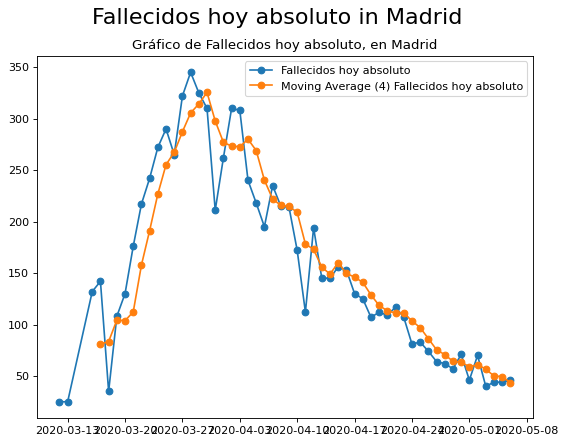

In [22]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Madrid")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension,4)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-09,4.491486,0.000000,47.231464,4.491486,4.491486,1.817405,1.817405,1.817405,1.817405,1.817405,1.817405,0.0,0.0,0.0,6.308891
2,2020-03-10,19.392712,0.000000,59.402623,19.392712,19.392712,-0.379011,-0.379011,-0.379011,-0.379011,-0.379011,-0.379011,0.0,0.0,0.0,19.013700
3,2020-03-11,34.293937,0.000000,66.771091,34.293937,34.293937,-5.686436,-5.686436,-5.686436,-5.686436,-5.686436,-5.686436,0.0,0.0,0.0,28.607502
4,2020-03-12,49.195163,12.536214,93.492302,49.195163,49.195163,2.381102,2.381102,2.381102,2.381102,2.381102,2.381102,0.0,0.0,0.0,51.576265
5,2020-03-13,64.096388,24.400088,108.193172,64.096388,64.096388,1.281213,1.281213,1.281213,1.281213,1.281213,1.281213,0.0,0.0,0.0,65.377601
6,2020-03-16,108.800065,72.942416,148.362841,108.800065,108.800065,1.817405,1.817405,1.817405,1.817405,1.817405,1.817405,0.0,0.0,0.0,110.617470
7,2020-03-17,123.701290,84.686723,166.520916,123.701290,123.701290,-0.379011,-0.379011,-0.379011,-0.379011,-0.379011,-0.379011,0.0,0.0,0.0,123.322279
8,2020-03-18,138.602516,95.475465,176.820213,138.602516,138.602516,-5.686436,-5.686436,-5.686436,-5.686436,-5.686436,-5.686436,0.0,0.0,0.0,132.916080
9,2020-03-19,153.503742,116.951737,193.807429,153.503742,153.503742,2.381102,2.381102,2.381102,2.381102,2.381102,2.381102,0.0,0.0,0.0,155.884843
10,2020-03-20,168.404967,127.197268,212.247985,168.404967,168.404967,1.281213,1.281213,1.281213,1.281213,1.281213,1.281213,0.0,0.0,0.0,169.686180


Prediccion total para Fallecidos hoy absoluto : 8517.143085496982


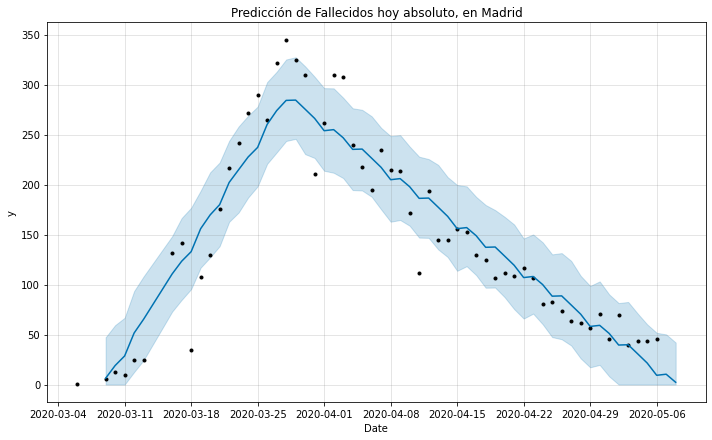

In [23]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

link="Prediccion_Fallecidos_hoy_absoluto_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
                                 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en Madrid, cambian dia a dia
2020-05-06      3071.108258
2020-05-05      3010.757688
2020-05-04      2966.408223
2020-05-03      2942.873811
datos reales    2880.000000
dtype: float64


,2020-05-06,2020-05-05,2020-05-04,2020-05-03,datos reales
ds,,,,,
2020-04-09,205.986537,206.601897,205.780431,202.660250,214.0
2020-04-10,197.887374,198.542274,197.787815,195.085510,172.0
2020-04-11,186.254382,186.648430,187.582042,185.231290,112.0
2020-04-12,186.546848,186.904181,186.511116,185.248437,194.0
2020-04-13,177.427545,177.750200,177.140623,173.585855,145.0
2020-04-14,168.235034,168.457033,164.316269,162.709658,145.0
2020-04-15,155.931515,151.055410,149.986077,148.083608,156.0
2020-04-16,157.006475,156.602154,155.407171,153.307757,153.0
2020-04-17,148.914009,148.543191,147.415532,145.733017,130.0


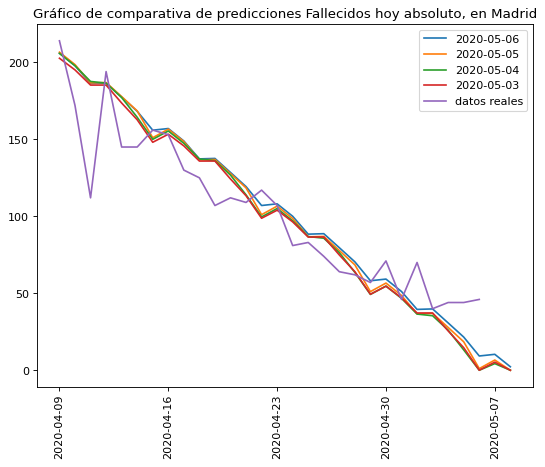

In [24]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Compare_Fallecidos_hoy_absoluto_Madrid"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,0,NaN
2020-03-16,8,NaN
2020-03-17,6,3.75
2020-03-18,23,9.25
2020-03-19,14,12.75
2020-03-20,27,17.50
2020-03-21,40,26.00
2020-03-22,69,37.50


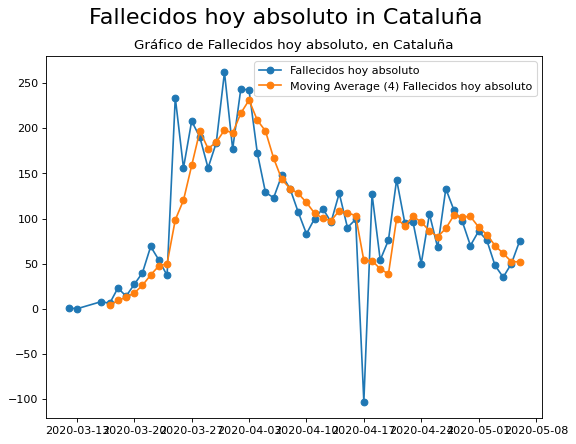

In [25]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Cataluña")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2,2020-03-12,8.806654,0.000000,60.291596,8.806654,8.806654,0.792329,0.792329,0.792329,0.792329,0.792329,0.792329,0.0,0.0,0.0,9.598984
3,2020-03-16,41.309576,0.000000,81.259220,41.309576,41.309576,-10.499380,-10.499380,-10.499380,-10.499380,-10.499380,-10.499380,0.0,0.0,0.0,30.810196
4,2020-03-17,49.435307,4.437501,103.724213,49.435307,49.435307,6.947855,6.947855,6.947855,6.947855,6.947855,6.947855,0.0,0.0,0.0,56.383162
5,2020-03-18,57.561037,20.821780,118.558487,57.561037,57.561037,11.908383,11.908383,11.908383,11.908383,11.908383,11.908383,0.0,0.0,0.0,69.469421
6,2020-03-19,65.686768,18.886320,117.219617,65.686768,65.686768,0.792329,0.792329,0.792329,0.792329,0.792329,0.792329,0.0,0.0,0.0,66.479097
7,2020-03-20,73.812498,31.893222,128.195622,73.812498,73.812498,6.039866,6.039866,6.039866,6.039866,6.039866,6.039866,0.0,0.0,0.0,79.852364
8,2020-03-21,81.938229,39.662045,140.647077,81.938229,81.938229,5.099871,5.099871,5.099871,5.099871,5.099871,5.099871,0.0,0.0,0.0,87.038100
9,2020-03-22,90.063959,17.098099,119.301441,90.063959,90.063959,-20.288924,-20.288924,-20.288924,-20.288924,-20.288924,-20.288924,0.0,0.0,0.0,69.775036
10,2020-03-23,98.189690,39.174545,139.375928,98.189690,98.189690,-10.499380,-10.499380,-10.499380,-10.499380,-10.499380,-10.499380,0.0,0.0,0.0,87.690310
11,2020-03-24,106.315420,65.192875,163.861572,106.315420,106.315420,6.947855,6.947855,6.947855,6.947855,6.947855,6.947855,0.0,0.0,0.0,113.263275


Prediccion total para Fallecidos hoy absoluto : 6021.9776561404315


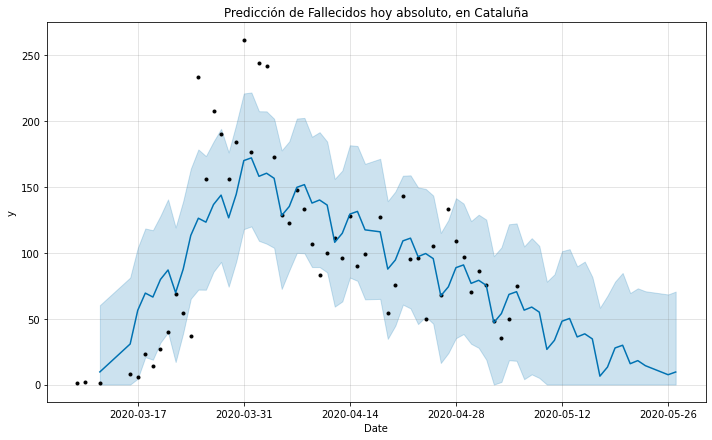

In [26]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'
link="Prediccion_Fallecidos_hoy_absoluto_Cataluña"


prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR)
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,NaN,NaN
2020-03-13,1.0,NaN
2020-03-16,8.0,NaN
2020-03-17,3.0,NaN
2020-03-18,10.0,5.50
2020-03-19,7.0,7.00
2020-03-20,14.0,8.50
2020-03-21,12.0,10.75
2020-03-22,19.0,13.00


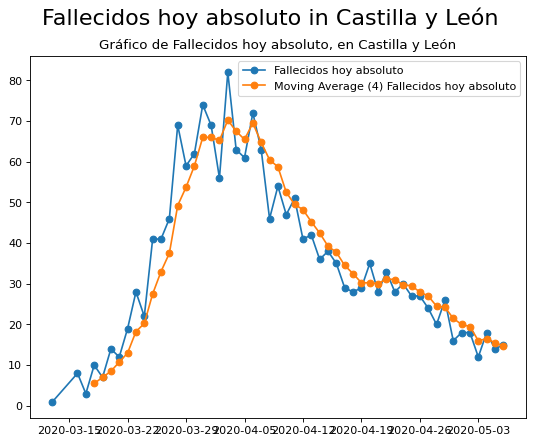

In [27]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla y León',dimension)

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CyL")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-16,1.759268,0.000000,12.278548,1.759268,1.759268,2.939131,2.939131,2.939131,2.939131,2.939131,2.939131,0.0,0.0,0.0,4.698399
2,2020-03-17,5.938817,0.000000,12.419405,5.938817,5.938817,-1.286470,-1.286470,-1.286470,-1.286470,-1.286470,-1.286470,0.0,0.0,0.0,4.652346
3,2020-03-18,10.118366,2.666916,19.131784,10.118366,10.118366,1.011658,1.011658,1.011658,1.011658,1.011658,1.011658,0.0,0.0,0.0,11.130024
4,2020-03-19,14.297915,3.226140,18.769022,14.297915,14.297915,-3.339755,-3.339755,-3.339755,-3.339755,-3.339755,-3.339755,0.0,0.0,0.0,10.958160
5,2020-03-20,18.477464,12.766023,28.430462,18.477464,18.477464,2.044094,2.044094,2.044094,2.044094,2.044094,2.044094,0.0,0.0,0.0,20.521558
6,2020-03-21,22.657013,15.245804,31.144685,22.657013,22.657013,0.788932,0.788932,0.788932,0.788932,0.788932,0.788932,0.0,0.0,0.0,23.445945
7,2020-03-22,26.836562,16.500355,33.039781,26.836562,26.836562,-2.157590,-2.157590,-2.157590,-2.157590,-2.157590,-2.157590,0.0,0.0,0.0,24.678972
8,2020-03-23,31.016111,25.767079,42.245028,31.016111,31.016111,2.939131,2.939131,2.939131,2.939131,2.939131,2.939131,0.0,0.0,0.0,33.955241
9,2020-03-24,35.195659,25.611086,41.995672,35.195659,35.195659,-1.286470,-1.286470,-1.286470,-1.286470,-1.286470,-1.286470,0.0,0.0,0.0,33.909189
10,2020-03-25,39.375208,31.984862,48.447709,39.375208,39.375208,1.011658,1.011658,1.011658,1.011658,1.011658,1.011658,0.0,0.0,0.0,40.386867


Prediccion total para Fallecidos hoy absoluto : 1886.913863348383


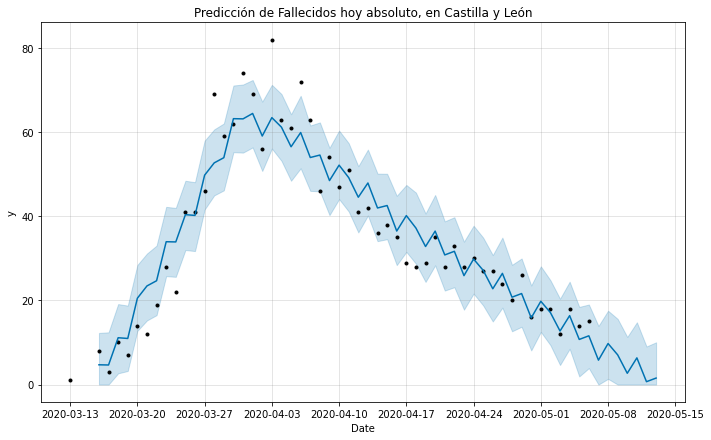

In [28]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla y León'
link="Prediccion_Fallecidos_hoy_absoluto_CyL"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,4,NaN
2020-03-16,12,NaN
2020-03-17,0,4.25
2020-03-18,11,6.75
2020-03-19,14,9.25
2020-03-20,20,11.25
2020-03-21,22,16.75
2020-03-22,28,21.00


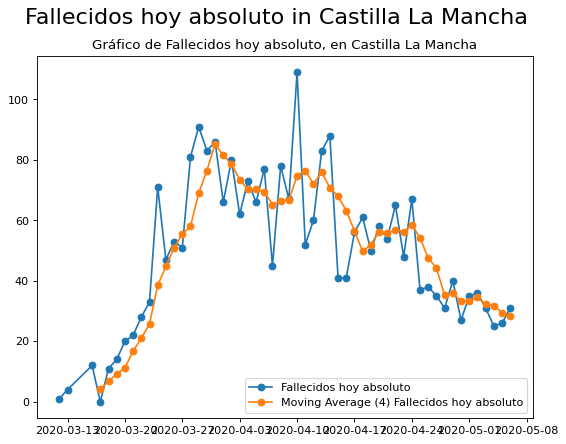

In [29]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla La Mancha',dimension)
Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CM")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-13,3.465169,0.000000,22.294985,3.465169,3.465169,3.630404,3.630404,3.630404,3.630404,3.630404,3.630404,0.0,0.0,0.0,7.095573
2,2020-03-16,15.403403,0.959931,33.471845,15.403403,15.403403,1.861832,1.861832,1.861832,1.861832,1.861832,1.861832,0.0,0.0,0.0,17.265234
3,2020-03-18,23.362225,5.276682,36.959136,23.362225,23.362225,-1.826181,-1.826181,-1.826181,-1.826181,-1.826181,-1.826181,0.0,0.0,0.0,21.536044
4,2020-03-19,27.341636,6.775445,37.414603,27.341636,27.341636,-4.641123,-4.641123,-4.641123,-4.641123,-4.641123,-4.641123,0.0,0.0,0.0,22.700513
5,2020-03-20,31.321047,17.997336,50.412702,31.321047,31.321047,3.630404,3.630404,3.630404,3.630404,3.630404,3.630404,0.0,0.0,0.0,34.951451
6,2020-03-21,35.300458,16.787322,48.935648,35.300458,35.300458,-1.556887,-1.556887,-1.556887,-1.556887,-1.556887,-1.556887,0.0,0.0,0.0,33.743571
7,2020-03-22,39.279869,22.417120,53.224112,39.279869,39.279869,-1.471557,-1.471557,-1.471557,-1.471557,-1.471557,-1.471557,0.0,0.0,0.0,37.808312
8,2020-03-23,43.259280,29.429046,61.261254,43.259280,43.259280,1.861832,1.861832,1.861832,1.861832,1.861832,1.861832,0.0,0.0,0.0,45.121112
9,2020-03-24,47.238691,35.920990,68.852782,47.238691,47.238691,4.003514,4.003514,4.003514,4.003514,4.003514,4.003514,0.0,0.0,0.0,51.242205
10,2020-03-25,51.218102,32.413112,64.788368,51.218102,51.218102,-1.826181,-1.826181,-1.826181,-1.826181,-1.826181,-1.826181,0.0,0.0,0.0,49.391921


Prediccion total para Fallecidos hoy absoluto : 2872.148192216697


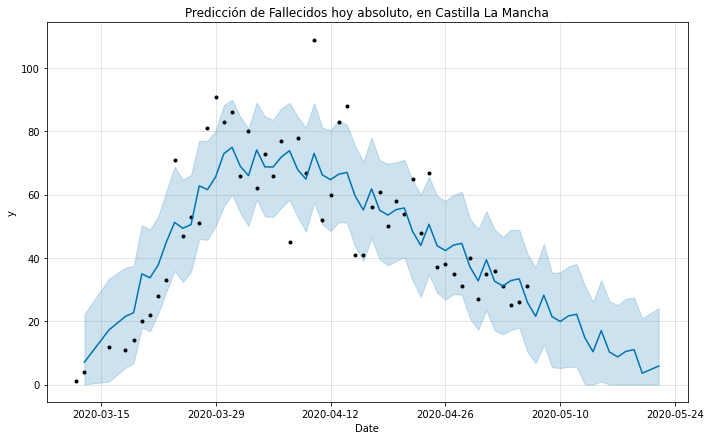

In [30]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla La Mancha'
link="Prediccion_Fallecidos_hoy_absoluto_CM"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en Castilla La Mancha, cambian dia a dia
2020-05-06      1274.119613
2020-05-05      1253.982868
2020-05-04      1365.709789
2020-05-03      1356.140577
datos reales    1021.000000
dtype: float64


,2020-05-06,2020-05-05,2020-05-04,2020-05-03,datos reales
ds,,,,,
2020-04-14,67.025234,66.740443,66.449307,67.761715,88.0
2020-04-15,59.595437,58.578176,56.934857,58.278882,41.0
2020-04-16,55.180375,54.842882,53.095825,54.520549,41.0
2020-04-17,61.851783,61.622998,59.868028,61.327182,56.0
2020-04-18,55.064372,55.044098,53.554647,54.637218,61.0
2020-04-19,53.549552,53.601232,52.356862,53.204338,50.0
2020-04-20,55.282791,55.295309,54.518828,56.843095,58.0
2020-04-21,55.824297,55.429941,56.904553,57.517035,54.0
2020-04-22,48.394426,47.267155,47.386732,48.034180,65.0


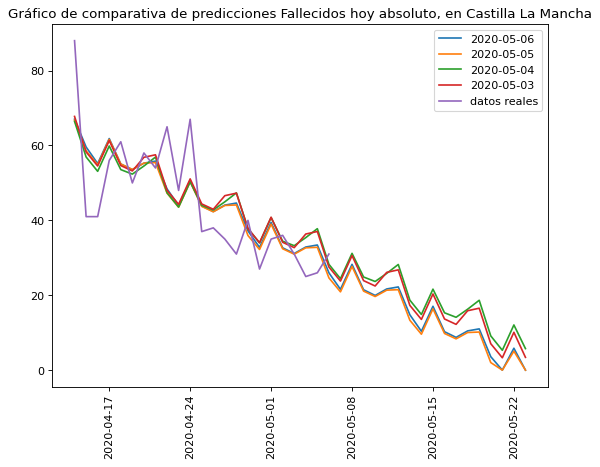

In [31]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla La Mancha'
link="Prediccion_Compare_Fallecidos_hoy_absoluto_CM"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-21,12199.729662,3211.935308,18400.648623,12199.729662,12199.729662,-1719.545409,-1719.545409,-1719.545409,-1719.545409,-1719.545409,-1719.545409,0.0,0.0,0.0,10480.184252
1,2020-03-22,12172.220023,2172.570183,17266.440282,12172.220023,12172.220023,-2240.593477,-2240.593477,-2240.593477,-2240.593477,-2240.593477,-2240.593477,0.0,0.0,0.0,9931.626545
2,2020-03-23,12144.710384,6653.648562,21649.052314,12144.710384,12144.710384,2207.763492,2207.763492,2207.763492,2207.763492,2207.763492,2207.763492,0.0,0.0,0.0,14352.473876
3,2020-03-24,12117.200745,5477.843007,20928.874296,12117.200745,12117.200745,1386.519870,1386.519870,1386.519870,1386.519870,1386.519870,1386.519870,0.0,0.0,0.0,13503.720615
4,2020-03-25,12089.691106,5850.423749,19509.724011,12089.691106,12089.691106,471.562052,471.562052,471.562052,471.562052,471.562052,471.562052,0.0,0.0,0.0,12561.253158
5,2020-03-26,12062.181467,4732.749289,19917.316707,12062.181467,12062.181467,287.312581,287.312581,287.312581,287.312581,287.312581,287.312581,0.0,0.0,0.0,12349.494049
6,2020-03-27,12034.671829,4347.327327,18931.478968,12034.671829,12034.671829,-393.019108,-393.019108,-393.019108,-393.019108,-393.019108,-393.019108,0.0,0.0,0.0,11641.652720
7,2020-03-28,12007.162190,2307.376084,17940.801477,12007.162190,12007.162190,-1719.545409,-1719.545409,-1719.545409,-1719.545409,-1719.545409,-1719.545409,0.0,0.0,0.0,10287.616781
8,2020-03-29,11979.652552,1746.380356,17636.540058,11979.652552,11979.652552,-2240.593477,-2240.593477,-2240.593477,-2240.593477,-2240.593477,-2240.593477,0.0,0.0,0.0,9739.059074
9,2020-03-30,11952.142914,7007.058316,21742.746631,11952.142914,11952.142914,2207.763492,2207.763492,2207.763492,2207.763492,2207.763492,2207.763492,0.0,0.0,0.0,14159.906406


Prediccion total para Hospitalizados : 4806514.370799495


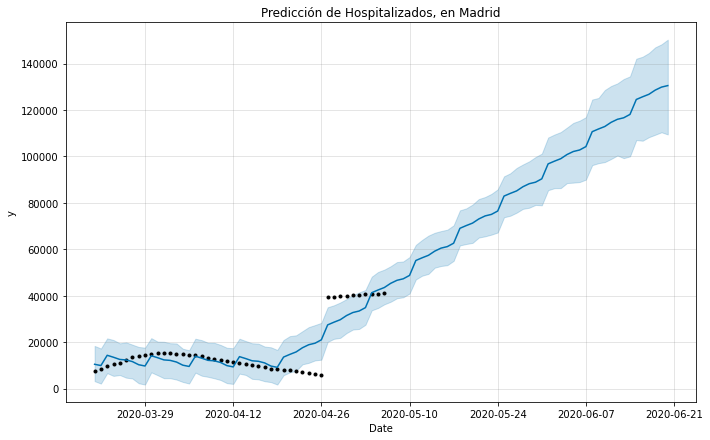

In [32]:
dimension = 'Hospitalizados'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Hospitalizados_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )

,Proporcion Curados hoy absoluto / Casos hoy absoluto,Moving Average (4) Proporcion Curados hoy absoluto / Casos hoy absoluto
Fecha,,
2020-03-12,0.000000,NaN
2020-03-13,0.000000,NaN
2020-03-16,0.000000,NaN
2020-03-17,0.000000,0.000000
2020-03-18,0.000000,0.000000
2020-03-19,0.000000,0.000000
2020-03-20,0.000000,0.000000
2020-03-21,0.000000,0.000000
2020-03-22,0.000000,0.000000


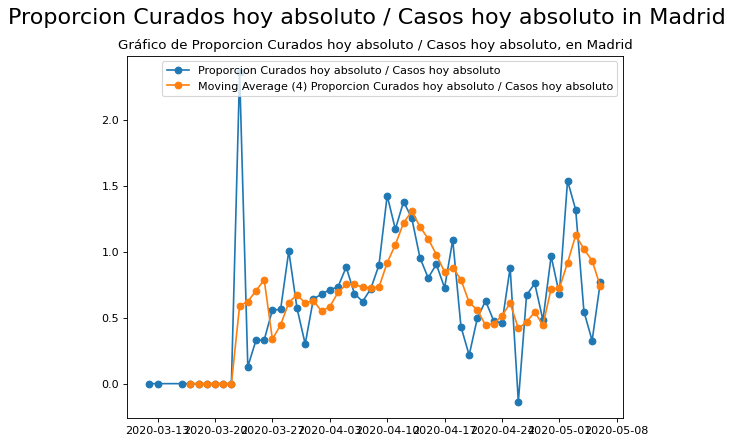

In [33]:
dimension = 'Proporcion Curados hoy absoluto / Casos hoy absoluto'
report_single_location_single_dimension('Madrid',dimension)


# ¿ Son reales estas cifras ? 
 
 Según reportaje de el mundo :https://www.elmundo.es/madrid/2020/04/07/5e8c427d21efa0b1668b45d6.html
 
   Entre los días 15 y 31 de marzo fallecieron en Madrid capital, "por todas las causas", aunque la mayoría por coronavirus, 5.950 personas, cuando en 2019, en el mismo lapso, murieron 1.100 personas

In [34]:
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)

Insertar_Enlace("Reales")

comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

madrid_muertos_segun_sanidad = comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

display(HTML ("Madrid muertos segun, <b>sanidad</b>, segunda quincena de Marzo:  <b>" + str(madrid_muertos_segun_sanidad)+"</b>"))

##

madrid_muertos_segun_interior = 5950 - 1100


display(HTML ("Madrid muertos segun, <b>interior</b>, mismo intervalo: <b>" + str(madrid_muertos_segun_interior)+"</b>"))


porcentaje_error = (madrid_muertos_segun_interior - madrid_muertos_segun_sanidad) / madrid_muertos_segun_sanidad


display(HTML ("La diferencia porcentual entre los muertos de sanidad e interior es de  <b>" + str(porcentaje_error) + "</b>") )

prediccion_muertos = comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error)



display(HTML ("El numero de <b>fallecidos en Madrid</b>, hasta ahora es de <b>" + str(comunidad['Fallecidos hoy absoluto'].sum()) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos)) + "</b> muertos" 
                                           ) )
Dimension = 'Fallecidos hoy absoluto'
df = Get_Dimension_CCAA(Dimension)

df['Total Fallecidos'] = df.sum(axis=1)

total_muertos_españa = int(df['Total Fallecidos'].sum())
prediccion_muertos_españa = total_muertos_españa* (1+porcentaje_error)

display(HTML ("El numero de <b>fallecidos en España</b>, hasta ahora es de <b>" + str(total_muertos_españa) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos_españa)) + "</b> muertos"
                                           ))

In [35]:
from datetime import datetime

COMUNIDAD_A_CONSIDERAR = 'Madrid'
#comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)


comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

3522

Text(0.5, 1.0, 'Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior')

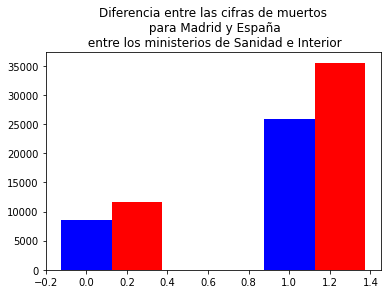

In [36]:
y = [comunidad['Fallecidos hoy absoluto'].sum(),total_muertos_españa]
z = [comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error), total_muertos_españa* (1+porcentaje_error)]

X = np.arange(2)

ax=plt.subplot(111)
plt.bar(X+0, y,color = 'b', width = 0.25)
plt.bar(X+0.25, z,color = 'r', width = 0.25)


ax.set_title("Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior")
